In [30]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 8

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [4]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [5]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [6]:
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)
vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [7]:
vs

MCState(
  hilbert = Spin(s=1/2, total_sz=0.0, N=8),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 28), n_chains = 16, n_sweeps = 8, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[1671743544 4147088406]),
  n_parameters = 144)

In [8]:
vs_i_parameters = vs.parameters.copy()

In [9]:
vs_i_parameters['Dense_0']['bias']

Array([ 0.00336065-0.01443408j, -0.01108901+0.00508087j,
       -0.00206165+0.00278628j, -0.00346453-0.00573537j,
        0.00494045+0.00124047j,  0.00609034-0.00054072j,
       -0.00066151-0.0122903j ,  0.00153494+0.01034674j,
       -0.00661074+0.00341523j, -0.0121809 +0.01432423j,
       -0.00435903-0.00398798j, -0.00399725-0.00693299j,
       -0.00949765-0.00380777j,  0.01565181+0.00486853j,
        0.00657057+0.00470785j, -0.0055708 +0.00809499j],      dtype=complex128)

In [10]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True

In [11]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []

In [12]:
gs.run(out='test', n_iter=300, obs={'Structure Factor': structure_factor}, callback=save_params)

100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 16.54it/s, Energy=-13.40306+0.00001j ± 0.00030 [σ²=0.00009, R̂=1.0164]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.06362414360046387
   	Params: 0.0019540786743164062,)

In [13]:
vs.parameters['Dense_0']['bias']

Array([-5.37818308e-04-3.20890695e-03j, -4.76439069e-03+5.58883573e-03j,
       -2.46920132e-03-1.65751929e-03j, -2.12772985e-03-2.67160584e-04j,
        3.42257440e-03-1.39743518e-03j, -3.97555129e-04-1.12649593e-03j,
        5.22770081e-04-4.69507755e-03j,  3.29672191e-03+1.39842396e-03j,
       -1.42080189e-03-1.67428516e-03j, -3.33661438e-03+2.13550445e-03j,
       -9.42375691e-05-3.62203075e-03j, -1.44054131e-03+2.16367539e-03j,
       -4.11882014e-04-8.46298937e-04j,  2.62217685e-03+6.35502206e-03j,
        5.69112344e-06+1.15491258e-05j, -4.61411363e-03+5.32812014e-03j],      dtype=complex128)

In [14]:
len(parameters_list)

300

In [15]:
parameters_list[-1]['Dense_0']['bias']

Array([-5.41288360e-04-3.21582624e-03j, -4.76912634e-03+5.58294662e-03j,
       -2.47261348e-03-1.66731871e-03j, -2.13850020e-03-2.88635170e-04j,
        3.43184702e-03-1.40673275e-03j, -3.85612462e-04-1.14764133e-03j,
        4.96198938e-04-4.68830455e-03j,  3.27960596e-03+1.43367669e-03j,
       -1.40030274e-03-1.67084262e-03j, -3.34973462e-03+2.14466588e-03j,
       -8.34822443e-05-3.61942730e-03j, -1.44361509e-03+2.14886639e-03j,
       -3.86126301e-04-8.77954456e-04j,  2.62087540e-03+6.35942038e-03j,
        3.86948663e-06+3.79886096e-06j, -4.61021735e-03+5.34297948e-03j],      dtype=complex128)

In [16]:
def info(e):
    head   = list(e.keys())[0]
    body   = list(e[head].keys())
    bias   = e[head][body[0]]
    kernel = e[head][body[1]]
    return  head, body, list(bias), list(kernel)
def real(c):
    return float(np.real(c))  
def img(c):
    return float(np.imag(c))    
def r_i(c):
    return real(c),img(c)   

In [17]:
head, body, bias_list,kernel_list = info(parameters_list[-1])

In [18]:
len(bias_list)

16

In [73]:
real_df = pd.DataFrame()
img_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for bias in bias_list:
        nr, ni = r_i(bias); 
        real_v.append(nr)
        img_v.append(ni)   
    
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
        
    real_df = pd.concat([real_df,real_row_df])
    img_df  = pd.concat([img_df,img_row_df])   

In [74]:
real_df.shape

(300, 16)

In [75]:
img_df.shape

(300, 16)

In [80]:
real_df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.003361,-0.011089,-0.002062,-0.003465,0.004940,0.006090,-0.000662,0.001535,-0.006611,-0.012181,-0.004359,-0.003997,-0.009498,0.015652,0.006571,-0.005571
0,2,0.003623,-0.013162,0.000514,-0.004707,0.006193,0.003869,-0.000515,0.002680,-0.006497,-0.009596,-0.000946,-0.004647,-0.008836,0.017859,0.007754,-0.004914
0,3,0.002824,-0.010200,-0.001041,-0.003828,0.004906,0.002494,-0.002081,0.003911,-0.009075,-0.013403,-0.000553,-0.005097,-0.007616,0.013962,0.004064,-0.005729
0,4,0.003417,-0.009549,-0.001017,-0.003801,0.004973,0.001642,-0.002473,0.004971,-0.009208,-0.013327,-0.000583,-0.005305,-0.006591,0.013170,0.003998,-0.005891
0,5,0.003393,-0.009414,-0.000487,-0.003806,0.005266,0.001467,-0.002428,0.005347,-0.009315,-0.012876,-0.000371,-0.005454,-0.006209,0.013038,0.004275,-0.005939


In [77]:
real_df.columns

RangeIndex(start=0, stop=16, step=1)

In [79]:
real_df.insert(0, 'id', range(1, 1 + len(real_df)))

In [87]:
real_df.columns

Index(['id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='object')

In [81]:
img_df.insert(0, 'id', range(1, 1 + len(img_df)))

In [82]:
img_df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,-0.014434,0.005081,0.002786,-0.005735,0.001240,-0.000541,-0.012290,0.010347,0.003415,0.014324,-0.003988,-0.006933,-0.003808,0.004869,0.004708,0.008095
0,2,-0.016121,0.006178,-0.000212,-0.006320,0.000548,0.001666,-0.010958,0.008890,0.002311,0.012769,-0.002404,-0.009642,-0.004076,0.003060,0.002460,0.009876
0,3,-0.015614,0.005589,-0.002732,-0.007977,-0.002136,0.001295,-0.009583,0.008232,0.002872,0.010944,-0.001472,-0.008310,-0.002971,0.004618,-0.000857,0.010547
0,4,-0.014952,0.005047,-0.004280,-0.007520,-0.003075,0.000547,-0.009089,0.008346,0.003015,0.009883,-0.002491,-0.007425,-0.002926,0.004730,-0.001247,0.011142
0,5,-0.014616,0.004961,-0.004819,-0.007558,-0.003272,0.000760,-0.008429,0.008634,0.003456,0.009161,-0.002233,-0.007447,-0.002617,0.004738,-0.001763,0.011695


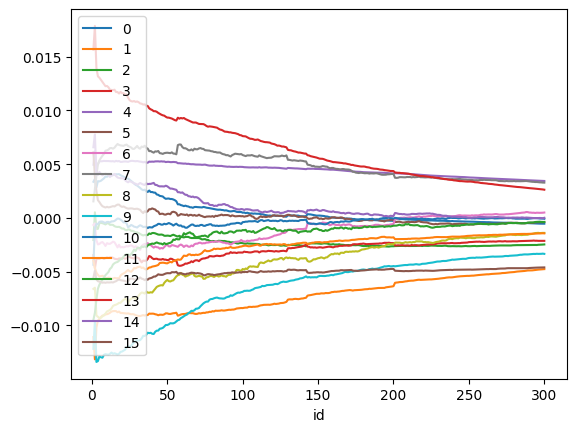

In [91]:
real_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()


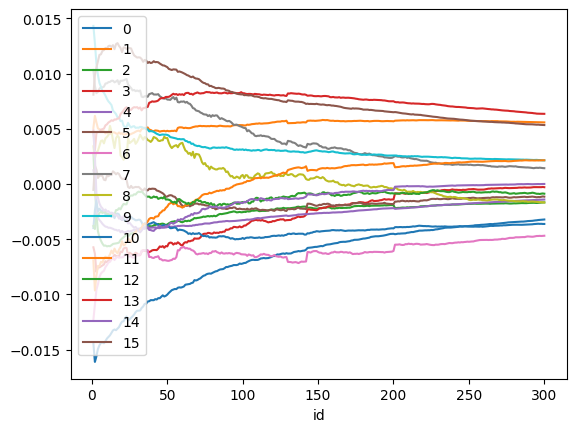

In [92]:
img_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

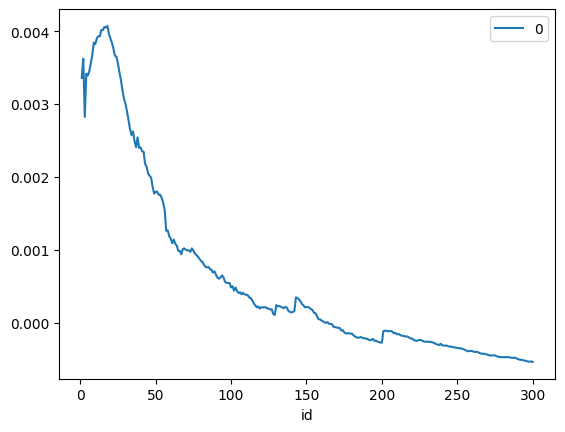

In [93]:
real_df.plot('id',y=[0])
plt.show()

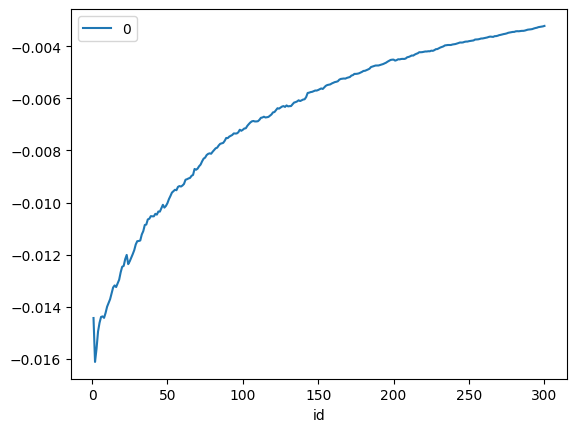

In [94]:
img_df.plot('id',y=[0])
plt.show()

In [96]:
len(kernel_list)

8

In [97]:
len(kernel_list[0])

16

In [98]:
(kernel_list[0][0])

Array(0.17870597-0.02869996j, dtype=complex128)

In [119]:
real_kernel_df = pd.DataFrame()
img_kernel_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for ks in kernel_list:
        for k in ks:
            nr, ni = r_i(k); 
            real_v.append(nr)
            img_v.append(ni) 
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
    
    real_kernel_df = pd.concat([real_kernel_df,real_row_df])
    img_kernel_df  = pd.concat([img_kernel_df,img_row_df])   

In [120]:
real_kernel_df.insert(0, 'id', range(1, 1 + len(real_kernel_df)))
img_kernel_df.insert(0, 'id', range(1, 1 + len(img_kernel_df)))

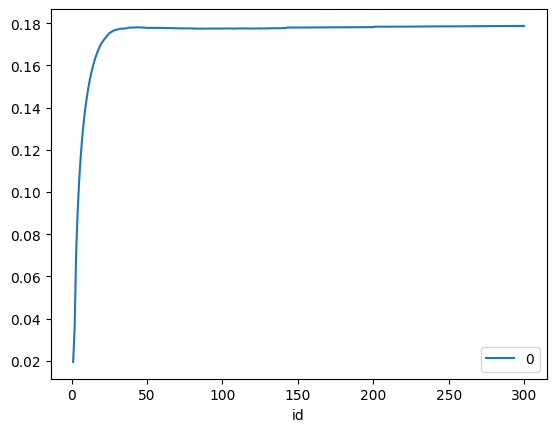

In [121]:
real_kernel_df.plot('id',y=[0])
plt.show()

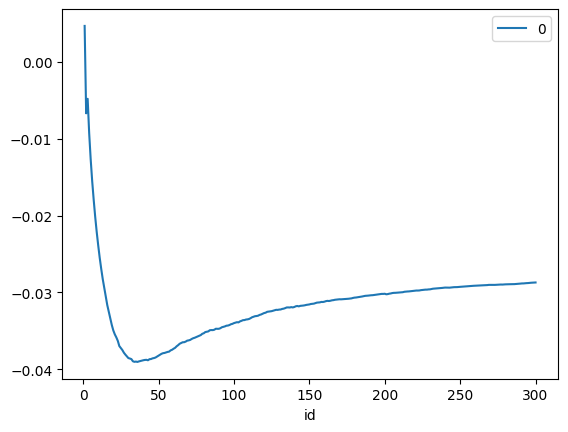

In [117]:
img_kernel_df.plot('id',y=[0])
plt.show()

In [127]:
img_kernel_df.columns

Index(['id',    0,    1,    2,    3,    4,    5,    6,    7,    8,
       ...
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127],
      dtype='object', length=129)

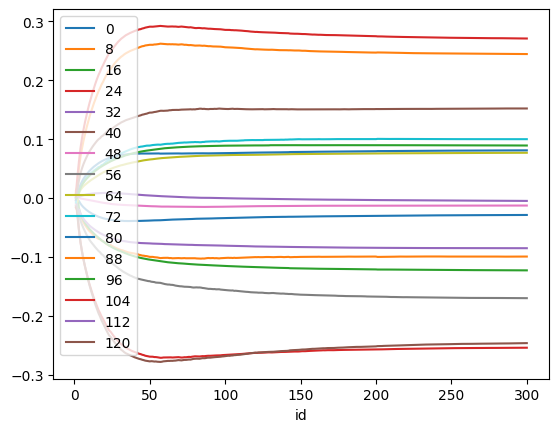

In [130]:
yt = []
for i in range(0,128): 
    if i % 8 ==0:
        yt.append(i)  
img_kernel_df.plot('id',y=yt)
plt.show()

In [124]:
yt = []
for i in range(0,128): 
    yt.append(i)        

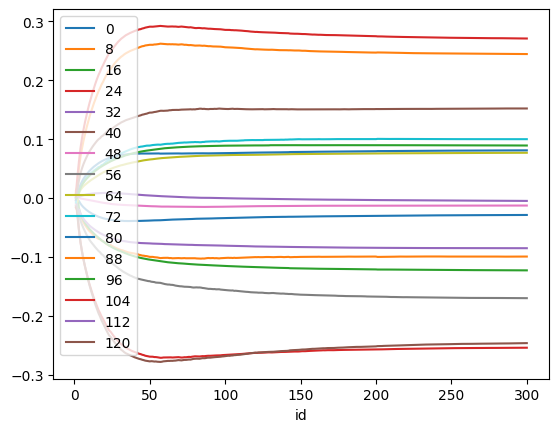

In [132]:
img_kernel_df.plot('id',y=yt)
plt.show()

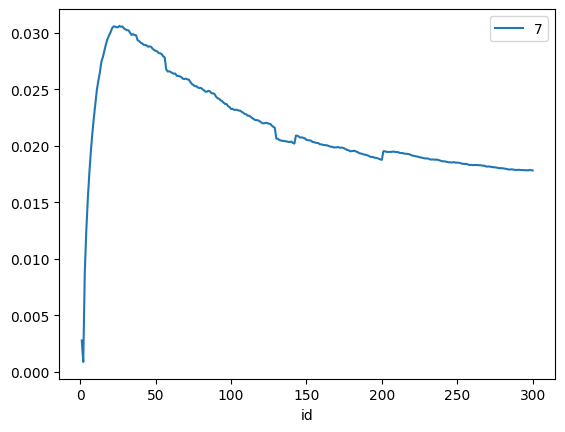

In [133]:
real_kernel_df.plot('id',y=[7])
plt.show()

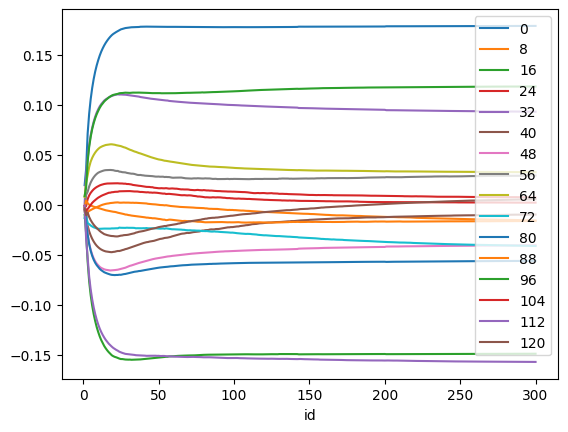

In [131]:
yt = []
for i in range(0,128): 
    if i % 8 ==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

In [113]:
real_df.shape

(300, 128)

In [112]:
real_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.019498,-0.006162,-0.017026,-0.003171,0.000241,0.000908,-0.010394,0.002767,-0.005643,-0.011781,...,-0.004118,-0.010768,-0.003746,-0.007639,0.020273,0.005051,-0.012122,0.013904,-0.006300,-0.001410
0,0.035777,-0.006151,-0.038564,-0.009529,-0.013387,0.004042,-0.013270,0.000874,-0.013299,0.004194,...,0.024809,-0.021453,-0.010496,0.017598,0.030226,0.019735,-0.017119,0.021497,0.001089,0.007978
0,0.071237,-0.013813,-0.079913,-0.016082,-0.025131,-0.001143,-0.020502,0.008781,-0.007629,-0.021966,...,0.033925,-0.036186,-0.007903,0.018877,0.043732,0.025595,-0.031292,0.048444,-0.003377,0.005910
0,0.091008,-0.017293,-0.104064,-0.019346,-0.034181,-0.003383,-0.025114,0.012477,-0.006278,-0.030188,...,0.045612,-0.048476,-0.012329,0.026615,0.056002,0.031629,-0.040037,0.063095,-0.003621,0.009056
0,0.105429,-0.020125,-0.122048,-0.021749,-0.041078,-0.005062,-0.028130,0.015270,-0.005424,-0.036583,...,0.054202,-0.057180,-0.015463,0.032380,0.065078,0.036021,-0.046340,0.073951,-0.003346,0.011403


In [105]:
len(real_v)

128

128

In [ ]:
real_df = pd.DataFrame()
img_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for bias in bias_list:
        nr, ni = r_i(bias); 
        real_v.append(nr)
        img_v.append(ni)   
    
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
        
    real_df = pd.concat([real_df,real_row_df])
    img_df  = pd.concat([img_df,img_row_df]) 

In [26]:
v_real

[-0.0005412883598028596,
 -0.004769126336294357,
 -0.002472613478624398,
 -0.0021385001988402253,
 0.003431847023095531,
 -0.0003856124615125337,
 0.0004961989376581199,
 0.00327960596053733,
 -0.0014003027435820353,
 -0.003349734619569475,
 -8.348224430809204e-05,
 -0.0014436150942999234,
 -0.0003861263007736504,
 0.002620875401414812,
 3.869486634385071e-06,
 -0.0046102173547813196]

In [24]:
v

[[1, -0.0005412883598028596, -0.003215826241082592],
 [2, -0.004769126336294357, 0.005582946623053462],
 [3, -0.002472613478624398, -0.0016673187131566278],
 [4, -0.0021385001988402253, -0.00028863517001733667],
 [5, 0.003431847023095531, -0.0014067327494845009],
 [6, -0.0003856124615125337, -0.001147641334960898],
 [7, 0.0004961989376581199, -0.004688304546509385],
 [8, 0.00327960596053733, 0.001433676689761937],
 [9, -0.0014003027435820353, -0.0016708426234071359],
 [10, -0.003349734619569475, 0.0021446658823354673],
 [11, -8.348224430809204e-05, -0.00361942730319757],
 [12, -0.0014436150942999234, 0.0021488663899913757],
 [13, -0.0003861263007736504, -0.0008779544560704002],
 [14, 0.002620875401414812, 0.006359420377421536],
 [15, 3.869486634385071e-06, 3.7988609634542173e-06],
 [16, -0.0046102173547813196, 0.005342979484005348]]

In [ ]:
i = 0
df = pd.DataFrame()
b_real = [];b_img = []
for bias in bias_list:
    nr, ni = r_i(bias); b_real.append(nr); b_img.append(ni); i = i +1
    v = []
    l = [index,nr,ni]
    v.append(l)
    dft = pd.DataFrame(v, columns=['real_bias', 'img_bias'])
    df = pd.concat([df,dft])

In [ ]:
df.head(10)

In [ ]:
plot = df.plot(title="DataFrame Plot")

In [ ]:
import pandas as pd


In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
head, body

In [ ]:
kernel_list

In [ ]:
bias_list